In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def boundary_pixels(nside, region_pix, *, nest=False):
    """
    Return those pixels in `region_pix` that have ≥1 neighbour outside the mask.
    Works for RING (default) or NEST ordering.
    """
    region_set = set(region_pix)                       # O(1) look-ups
    bdry = []
    for p in region_pix:
        nbrs = hp.get_all_neighbours(nside, p, nest=nest)
        # (nbrs may contain −1 at the poles → ignore)
        if any((q not in region_set) for q in nbrs if q >= 0):
            bdry.append(p)
    return np.array(bdry, dtype=np.int64)

def widest_separation(nside, region_pix, *, nest=False, block=4096):
    """Return the two farthest boundary pixels, the midpoint pixel,
       and their angular diameter (degrees).  RING-ordered input."""
    # --- boundary --------------------------------------------------------
    region_set = set(region_pix)
    bdry_pix = []
    for p in region_pix:
        nbrs = hp.get_all_neighbours(nside, p, nest=nest)
        if any((q not in region_set) for q in nbrs if q >= 0):
            bdry_pix.append(p)
    bdry_pix = np.array(bdry_pix, dtype=np.int64)

    if len(bdry_pix) < 2:
        raise ValueError("Need at least two boundary pixels")

    vecs = np.array(hp.pix2vec(nside, bdry_pix, nest=nest))   # 3 × N_b
    Nb   = vecs.shape[1]

    # --- search streamed -------------------------------------------------
    best_cos  = 1.0
    best_pair = (None, None)

    for s in range(0, Nb, block):
        e   = min(s + block, Nb)
        sub = vecs[:, s:e]              # 3 × b
        cos = sub.T @ vecs              # b × N_b   (fits in RAM)
        np.clip(cos, -1.0, 1.0, out=cos)

        flat_idx = cos.argmin()
        i_local, j = divmod(flat_idx, Nb)
        i = s + i_local

        if cos.flat[flat_idx] < best_cos:
            best_cos  = cos.flat[flat_idx]
            best_pair = (bdry_pix[i], bdry_pix[j])

    # --- midpoint --------------------------------------------------------
    v1 = np.array(hp.pix2vec(nside, best_pair[0], nest=nest))
    v2 = np.array(hp.pix2vec(nside, best_pair[1], nest=nest))
    v_mid = v1 + v2
    v_mid /= np.linalg.norm(v_mid)

    mid_pix = hp.vec2pix(nside, *v_mid, nest=nest)
    diameter_deg = np.degrees(np.arccos(best_cos))

    return best_pair[0], best_pair[1], mid_pix, diameter_deg

In [3]:
# Other params
nside = 1024

# Directory to write data to
cmb_survey = 'SPT'
wl_survey = 'dr3'

# Where data is
cmb_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/'
wl_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/wl_masks/'

cmb_mask_map = np.load(cmb_mask_dir + cmb_survey + '.npy')
wl_mask_map = np.load(wl_mask_dir + wl_survey + '.npy')

total_mask = cmb_mask_map + wl_mask_map

unmask = np.where(total_mask == 2)[0]

In [4]:
bound = boundary_pixels(nside, unmask)
pix1, pix2, center, diam = widest_separation(nside, bound)

theta, phi = hp.pixelfunc.pix2ang(nside, center)
dec, ra = -np.degrees(theta - np.pi / 2.), np.degrees(phi)
res = hp.nside2resol(nside, arcmin=True)

In [5]:
diam

85.46851725284964

In [6]:
mask = np.where(total_mask < 1.5)[0]
survey_map = np.arange(12*(nside**2)) + 1
survey_map[mask] = 0

In [7]:
xsize = 2048
patch = hp.gnomview(survey_map, 
                    rot=(ra, dec), 
                    xsize=xsize, 
                    reso=res,
                    no_plot=True,
                    return_projected_map=True)

In [8]:
patches = np.array([patch.data])

In [9]:
np.shape(patches)

(1, 2048, 2048)

In [10]:
patch_file = '/n/home09/kboone/software/Data/Patches/one_patch_nside_' + str(nside) + '_xsize_' + str(xsize) + '.npy'

patch_inds = (patches+0.01).astype(int) - 1
np.save(patch_file, patch_inds)

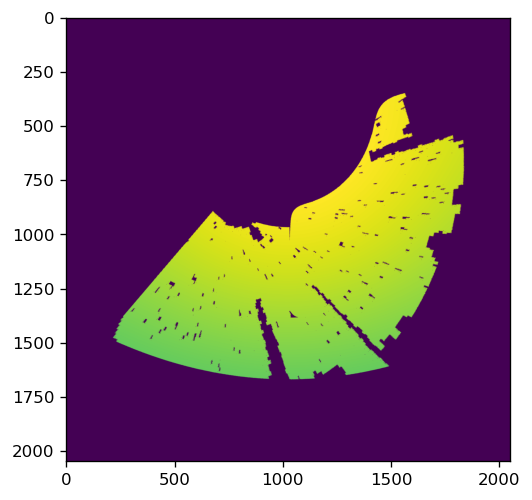

In [11]:
plt.figure(dpi = 120)
plt.imshow(patch_inds[0])
# for i in np.arange(8):
#     plt.axvline(x=256*i, color='white', lw=1)
#     plt.axhline(y=256*i, color='white', lw=1)
plt.show()